### Introduction

This notebook is an experiment of building a model that will predict if a rookie player will last at least 5 years in the league based on his stats.

In the National Basketball Association (NBA), a rookie is any player who has never played a game in the NBA until that year. At the end of the season the NBA awards the best rookie with the NBA Rookie of the Year Award.

Moving to the NBA league is a big deal for any basketball player. Sport commentators and fans are very excited to follow the start of their careers and guess how they will perform in the future.

In this experiment, LogisticRegression model is used.

### Import the libraries

In [2]:
import pandas as pd
import numpy as np

from sklearn.preprocessing import StandardScaler, PolynomialFeatures
import os
import sys
sys.path.append(os.path.abspath('..'))
from src.common_lib import DataReader, NBARawData
from src.models.aj_metrics import confusion_matrix, plot_roc

from sklearn.linear_model import LogisticRegression 
from sklearn.metrics import accuracy_score, roc_curve, auc
import matplotlib.pyplot as plt
from joblib import dump

from collections import Counter

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

%load_ext autoreload
%autoreload 2

In C:\Hnin\Anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In C:\Hnin\Anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In C:\Hnin\Anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fallback : 'cm' instead.
In C:\Hnin\Anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The validate_bool_maybe_none function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In C:\Hnin\Anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The savefig.jpeg_quality rc

### Load the data

In [3]:
# Instantiate the custom data reader class
data_reader = DataReader()

# Load Raw Train Data
train_df = data_reader.read_data(NBARawData.TRAIN)

# Load Test Raw Data
test_df = data_reader.read_data(NBARawData.TEST)

### Class Balance Check on Raw Data

Propotion:  0.2 :1
Counter({6669: 1, 1331: 1})


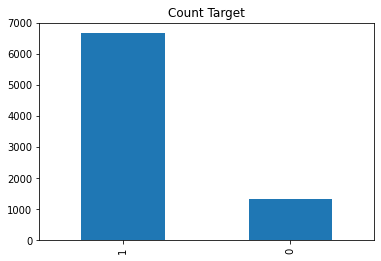

In [4]:
target_count = train_df["TARGET_5Yrs"].value_counts()
print('Propotion: ', round(target_count[0]/ target_count[1], 2), ":1")

print( Counter(target_count))
data_reader.plot_class_balance(train_df["TARGET_5Yrs"])

### Scaling with Standard Scaler

In [23]:
## Scaling
df_cleaned = train_df.copy()
target = df_cleaned.pop('TARGET_5Yrs')

train_df_scaled = data_reader.scale_features_by_standard_scaler(df_cleaned)
train_df_scaled

,Id_old,Id,GP,MIN,PTS,FGM,FGA,FG%,3P Made,3PA,...,FTM,FTA,FT%,OREB,DREB,REB,AST,STL,BLK,TOV
0,0.930059,-1.731834,1.006100,0.640574,0.123403,0.113959,0.047090,0.177269,-0.428374,-0.486911,...,0.655953,0.760387,0.070392,1.428377,-0.121037,0.266040,1.161949,1.107242,-0.055071,0.473210
1,-0.380914,-1.731401,0.714005,0.360766,0.748626,0.822648,0.465578,1.704465,-1.469853,-1.712288,...,1.087875,1.319370,-0.341888,3.210407,1.100107,1.608950,-0.681844,-0.364787,0.432148,0.196671
2,-0.286878,-1.730968,1.298195,0.058574,-0.640758,-0.535673,-0.482994,-0.293888,0.352736,0.361427,...,-1.071732,-1.076272,0.415557,-0.608229,-0.264701,-0.405415,-0.608092,-0.610125,-0.055071,-0.909485
3,1.743194,-1.730535,0.012976,0.058574,0.216029,0.409246,0.130788,1.282049,0.092366,-0.015612,...,-0.531830,-0.357579,-0.428180,-0.353653,-0.121037,-0.117649,0.129425,-0.610125,-0.176876,0.888019
4,-0.348731,-1.730102,0.012976,-0.086926,-0.826009,-0.653788,-0.789885,1.005854,0.613106,0.549947,...,-1.287692,-1.156127,-1.665021,1.682952,0.381787,0.793612,-0.903099,-0.610125,0.432148,-0.771215
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7995,-0.970776,1.730102,-1.798014,-1.049465,-1.265980,-1.244362,-1.236272,-0.700057,-0.949113,-0.958210,...,-1.071732,-1.076272,-0.543235,-0.990093,-0.264701,-0.645220,-0.829347,-0.855464,-0.055071,-1.186024
7996,1.212418,1.730535,-0.512795,-1.407619,-1.265980,-1.244362,-1.347869,0.664672,-0.428374,-0.675430,...,-1.287692,-1.235982,-0.121366,-0.099078,-0.767525,-0.597259,-1.124354,-1.591478,0.066734,-1.324294
7997,-0.331885,1.730968,1.298195,1.077074,0.794939,0.704533,0.772469,0.079788,-0.168004,-0.204131,...,1.519796,1.558934,-0.159718,-0.099078,-0.049205,-0.069687,1.309452,1.352580,-0.055071,0.749749
7998,-1.399219,1.731401,-1.389081,-1.217350,-1.103885,-1.067190,-1.096776,-0.732551,-1.469853,-1.240989,...,-0.855771,-0.996417,0.281326,-0.862805,-1.126685,-1.124831,-1.050602,-0.855464,0.066734,-1.047755


### Select Features

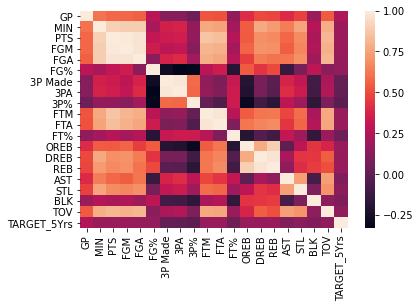

In [24]:
train_df_scaled['TARGET_5Yrs'] = target
selected_features = data_reader.select_feature_by_correlation(train_df_scaled)

In [25]:
selected_features

Index(['GP', 'MIN', 'FG%', '3P Made', '3P%', 'FTM', 'FT%', 'OREB', 'DREB',
       'AST', 'STL', 'BLK', 'TOV', 'TARGET_5Yrs'],
      dtype='object')

### Split Train and Test on Scaled Data with Selected Features

In [28]:
train_df_scaled  = train_df_scaled[selected_features]
X_train, X_val, y_train, y_val = data_reader.split_data(train_df_scaled)

,GP,MIN,FG%,3P Made,3P%,FTM,FT%,OREB,DREB,AST,STL,BLK,TOV
3617,0.071395,-0.523427,-0.261394,-1.209483,-0.480167,0.008072,-0.207657,-0.608229,-0.336533,-0.755595,-0.610125,-0.176876,-0.771215
1120,1.064519,0.248843,0.031048,0.352736,-0.467668,0.439993,0.731958,0.791937,1.315603,-0.681844,-0.119449,-0.176876,0.058402
3873,-0.746471,-1.452389,-1.333681,-0.688743,-1.417540,-1.287692,-0.265185,-1.244669,-1.414013,-0.091830,-0.610125,-0.664095,-1.324294
153,0.538748,0.080958,-0.683810,-0.428374,0.357221,-0.531830,-2.201944,-0.480941,-0.121037,-0.386837,-0.364787,-0.055071,-0.494676
2960,-1.038567,0.125727,-0.407615,-0.428374,-1.392544,-0.315869,-0.897987,-0.099078,-0.480197,-0.091830,-0.610125,0.066734,0.749749
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2181,0.655586,3.114075,0.112281,1.394215,1.413328,1.843737,-0.322712,1.046513,2.895908,1.309452,1.843256,0.066734,2.408983
2409,-0.220700,-0.422696,-1.772344,0.613106,-0.330187,-0.099909,-1.444499,-0.480941,-0.695693,-0.091830,0.616566,-0.176876,-0.771215
2033,-0.454376,-0.333157,-0.033940,0.873476,0.775914,-0.747791,0.127920,0.028210,0.094459,-0.460589,-0.364787,0.066734,-0.632946
1364,1.648710,3.281959,0.226009,0.352736,-1.261311,1.951717,-0.476119,2.446680,3.111404,1.899466,0.616566,0.432148,0.473210


Counter({1: 5326, 0: 1074})
Counter({1: 1343, 0: 257})


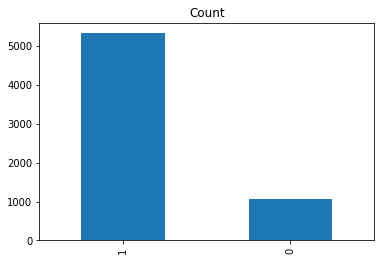

In [33]:
### Visualisation Before Sampling Classification Count
print( Counter(y_train))
data_reader.plot_class_balance(y_train)

Counter({1: 1343, 0: 257})


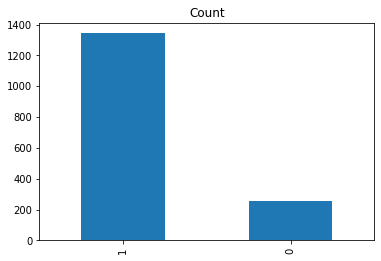

In [34]:
print(Counter(y_val))
data_reader.plot_class_balance(y_val)

### Re-sampling -  Over Sampling

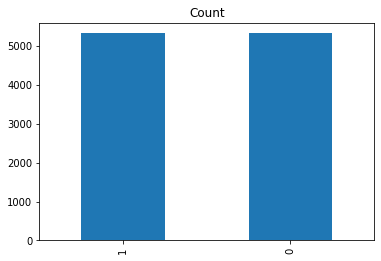

In [40]:
# Resample Train Data
X_train_res, y_train_res = data_reader.resample_data_upsample_smote(X_train, y_train)

# Re-plot the target
data_reader.plot_class_balance(y_train_res)

### Build The Model - Logistic Regression

In [42]:
log_reg = LogisticRegression().fit(X_train_res, y_train_res)

### Accuracy Test on Train Set

accuracy_score: 0.6613781449493052
        pred:0  pred:1
true:0    3610    1716
true:1    1891    3435


<module 'matplotlib.pyplot' from 'C:\\Hnin\\Anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

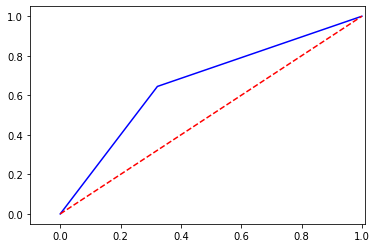

In [43]:
y_train_prob = log_reg.predict_proba(X_train_res)[:,1]

## Check Accuracy Score
y_pred=log_reg.predict(X_train_res)
print("accuracy_score:",accuracy_score(y_train_res, y_pred))
print(confusion_matrix(y_train_res, y_pred))

## Plot ROC
plot_roc(y_train_res, y_pred)

### Accuracy Check on Validation Set

accuracy_score: 0.63875
        pred:0  pred:1
true:0     170      87
true:1     491     852


<module 'matplotlib.pyplot' from 'C:\\Hnin\\Anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

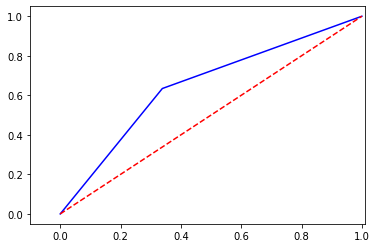

In [44]:
y_prob=log_reg.predict_proba(X_val)[:,1]

## Check Accuracy Score
y_pred=log_reg.predict(X_val)
print("accuracy_score:", accuracy_score(y_val, y_pred))
print(confusion_matrix(y_val, y_pred))

## Plot ROC
plot_roc(y_val, y_pred)


### Prediction on Test Set 

In [51]:
# Remove the target column, because the raw test set does not contain it
features_without_target = np.delete(selected_features, 13)
test_df = test_df[features_without_target]
test_df_scaled =  data_reader.scale_features_by_standard_scaler(test_df)


y_test_proba =log_reg.predict_proba(test_df_scaled)[:,1]


final_prediction_test = pd.DataFrame({'Id': range(0,3799), 'TARGET_5Yrs': [p for p in y_test_proba]})
final_prediction_test.to_csv("../reports/tin_submission_stdscale_smote_logistic_regression_selFeatures.csv", index=False)

final_prediction_test.head(10)

,Id,TARGET_5Yrs
0,0,0.477408
1,1,0.454545
2,2,0.732773
3,3,0.783287
4,4,0.412399
5,5,0.714216
6,6,0.333125
7,7,0.419366
8,8,0.559182
9,9,0.201586
